<a href="https://colab.research.google.com/github/ShlokVaibhav/AI_for_Analog_Design/blob/main/NGspice_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
! python --version    # Pyspice works with python  3.9 or lower
!wget https://github.com/ShlokVaibhav/AI_for_Analog_Design/blob/main/Model_Files/lib_90nm.txt    # fetch the spice.cir file


Python 3.11.11
--2025-10-18 14:19:05--  https://github.com/ShlokVaibhav/AI_for_Analog_Design/blob/main/Model_Files/lib_90nm.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘lib_90nm.txt’

lib_90nm.txt            [ <=>                ] 191.45K  --.-KB/s    in 0.03s   

2025-10-18 14:19:05 (6.49 MB/s) - ‘lib_90nm.txt’ saved [196043]



In [12]:
# Source: (S1) https://stackoverflow.com/questions/72133319/oserror-cannot-load-library-libngspice-so-libngspice-so-on-google-colab
# First answer
!pip install -q condacolab
!pip install matplotlib
!pip install numpy
import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [13]:
# Installing ngspice [S1] but inside the new environment [S2]
!conda install -c conda-forge ngspice-exe
!conda install -c conda-forge ngspice
!conda install -c conda-forge ngspice-lib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ngspice-exe


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.10.5  |       hbd8a1cb_0         152 KB  conda-forge
    certifi-2025.10.5          |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    gettext-0.25.1             |       h5888daf_0         525 KB  conda-forge
    gettext-tools-0.25.1       |       h5888daf_0         3.5 MB  conda-forge
    libasprintf-0.25.1         |       h8e693c7_0          52 KB  conda-forge
    libasprintf-devel-0.25.1   |       h8e693c7_0          34 KB  conda-forge
    libgettextpo-0.25.1        |       h5888daf_0         174 KB  conda-forge
    libgettextpo-devel-0.25.1  |       h5888daf_

In [96]:
# creating the spice file with 90nm predictive library
# inverter transient transfer curve
text = """CMOS inverter

.model mosnb3 NMOS level=8 version=3.3.0 tox=6.5n nch=2.4e17 nsub=5e16 vth0=0.3
.model mospb3 PMOS level=8 version=3.3.0 tox=6.5n pch=2.4e17 psub=5e16 vth0=0.3
.include "Model_Files/lib_90nm.txt"
.option TEMP=27C

Vpower VD 0 1.5
Vgnd VS 0 0

Vgate Ein VS PULSE(0 1.5 100n 50n 50n 200n 500n)

*MN0 Aus Ein VS VS MOSN W=10U L=0.18U
M1  Aus Ein VS VS nmos L=90n W=360n
*MP0 Aus Ein VD VD MOSP W=20U L=0.18U
M2  Aus Ein VD VD pmos L=90n W=360n

*R1 Aus VD 1K

.tran 0.5ns 600ns
.control
  run
  wrdata Aus.dat v(Aus)
  wrdata Ein.dat v(Ein)
.endc
.END"""

# Save to file
with open("NMOS_test.cir", "w") as f:
    f.write(text)

# Verify
!cat NMOS_test.cir


CMOS inverter

.model mosnb3 NMOS level=8 version=3.3.0 tox=6.5n nch=2.4e17 nsub=5e16 vth0=0.3
.model mospb3 PMOS level=8 version=3.3.0 tox=6.5n pch=2.4e17 psub=5e16 vth0=0.3
.include "Model_Files/lib_90nm.txt"
.option TEMP=27C

Vpower VD 0 1.5
Vgnd VS 0 0

Vgate Ein VS PULSE(0 1.5 100n 50n 50n 200n 500n)

*MN0 Aus Ein VS VS MOSN W=10U L=0.18U
M1  Aus Ein VS VS nmos L=90n W=360n
*MP0 Aus Ein VD VD MOSP W=20U L=0.18U
M2  Aus Ein VD VD pmos L=90n W=360n

*R1 Aus VD 1K

.tran 0.5ns 600ns
.control
  run
  wrdata Aus.dat v(Aus)
  wrdata Ein.dat v(Ein)
.endc
.END

In [97]:
#running ngspice in batch mode, output log saved in output.log
import os
os.system("ngspice -b -o output.log NMOS_test.cir")


0

In [98]:
# read log file
with open('output.log', 'r') as file:
    content = file.read()
    print(content)



Note: No compatibility mode selected!


Circuit: cmos inverter

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vd                                         1.5
vs                                           0
ein                                          0
aus                                    1.49991
vgate#branch                        4.5348e-09
vgnd#branch                        3.75561e-08
vpower#branch                     -3.75561e-08


No. of Data Rows : 1220
Note: Simulation executed from .control section 



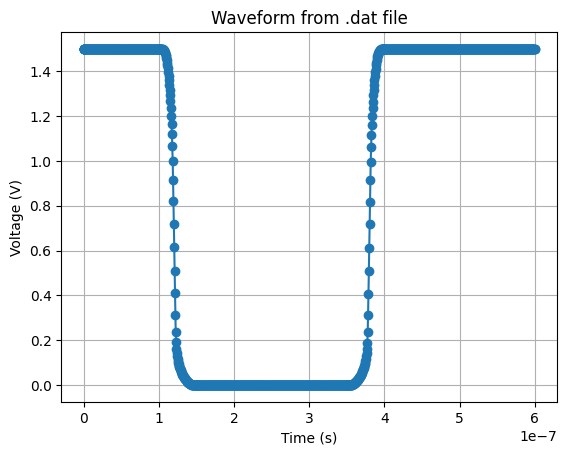

In [99]:
# plot inverter output
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('Aus.dat')  # your .dat file

# If your file has two columns
time = data[:, 0]   # first column
voltage = data[:, 1]  # second column

# Plot
plt.plot(time, voltage, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Waveform from .dat file')
plt.grid(True)
plt.show()
